In [3]:
import torch
from torchsummary import summary
from torcheval.metrics.functional import multiclass_accuracy

d:\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [10]:
from torch.utils.data import Dataset, DataLoader, random_split

In [15]:
from torchmetrics.classification import MulticlassAccuracy

In [17]:
import matplotlib.pyplot as plt

In [4]:
class MultiClassNN(torch.nn.Module):
    def __init__(self, input_shape, num_classes):
        super(MultiClassNN, self).__init__()
        
        self.fc1 = torch.nn.Linear(input_shape, 64)
        self.fc2 = torch.nn.Linear(64, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 16)
        self.fc5 = torch.nn.Linear(16, num_classes)
        
        self.activation = torch.relu
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        return x

In [7]:
df_train=pd.read_csv('data/train.csv')
df_test=pd.read_csv('data/test.csv')
X=df_train.drop(['Target','id'],axis=1).values
y=df_train['Target'].values
labelencoder=LabelEncoder()
y=labelencoder.fit_transform(y)
scalar=StandardScaler()
X=scalar.fit_transform(X)

In [8]:
BATCH_SIZE = 32
INPUT_SIZE = X.shape[1]
CLASSES = 3
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = MultiClassNN(INPUT_SIZE, CLASSES).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

summary(model, input_size=(INPUT_SIZE, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,368
            Linear-2                  [-1, 256]          16,640
            Linear-3                   [-1, 64]          16,448
            Linear-4                   [-1, 16]           1,040
            Linear-5                    [-1, 3]              51
Total params: 36,547
Trainable params: 36,547
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.14
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [11]:
class TabularMultiClassDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [13]:
dataset = TabularMultiClassDataset(X, y)
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
metric = MulticlassAccuracy(num_classes=3).to(device)

In [18]:
history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += metric(outputs, targets)
    running_loss /= len(train_loader)
    running_accuracy /= len(train_loader)
    history["train_loss"].append(running_loss)
    history["train_accuracy"].append(running_accuracy)
    
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_accuracy += metric(outputs, targets)
    running_loss /= len(val_loader)
    running_accuracy /= len(val_loader)
    history["val_loss"].append(running_loss)
    history["val_accuracy"].append(running_accuracy)

    print(f'Epoch {epoch}  TrainLoss: {str(history["train_loss"][-1])[:7]}  ValidationLoss: {str(history["val_loss"][-1])[:7]}')
    print(f'       TrainAccuracy:  {float(history["train_accuracy"][-1])}  ValidationAccuracy:  {float(history["val_accuracy"][-1])}')


Epoch 0  TrainLoss: 0.51037  ValidationLoss: 0.47757
       TrainAccuracy:  0.7543474435806274  ValidationAccuracy:  0.7762947678565979
Epoch 1  TrainLoss: 0.48710  ValidationLoss: 0.47325
       TrainAccuracy:  0.7624830007553101  ValidationAccuracy:  0.7662172317504883
Epoch 2  TrainLoss: 0.48221  ValidationLoss: 0.47089
       TrainAccuracy:  0.7637472748756409  ValidationAccuracy:  0.7842622995376587
Epoch 3  TrainLoss: 0.48043  ValidationLoss: 0.48223
       TrainAccuracy:  0.7677494287490845  ValidationAccuracy:  0.7755910158157349
Epoch 4  TrainLoss: 0.48919  ValidationLoss: 0.47314
       TrainAccuracy:  0.7616732120513916  ValidationAccuracy:  0.7769041061401367
Epoch 5  TrainLoss: 0.48049  ValidationLoss: 0.47575
       TrainAccuracy:  0.7690861821174622  ValidationAccuracy:  0.7736034393310547
Epoch 6  TrainLoss: 0.48011  ValidationLoss: 0.47585
       TrainAccuracy:  0.7681097388267517  ValidationAccuracy:  0.7687685489654541
Epoch 7  TrainLoss: 0.48275  ValidationLoss: 0.4

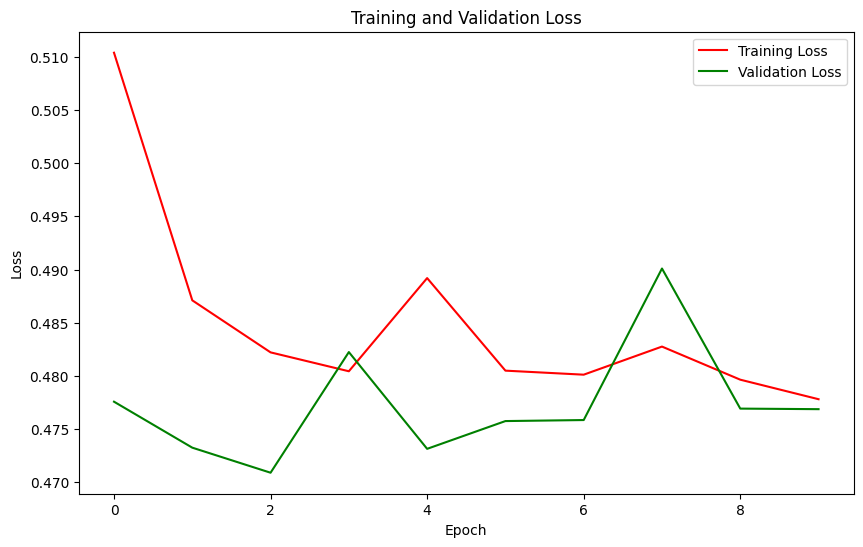

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label='Training Loss',color='r')
plt.plot(history["val_loss"], label='Validation Loss',color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
X_test=df_test.drop(['id'],axis=1).values
X_test=scalar.fit_transform(X_test)
X_Test_Tensor = torch.Tensor(X_test).to(device)
pred = model(X_Test_Tensor)
pred = torch.argmax(pred, 1).cpu().numpy()
pred = labelencoder.inverse_transform(pred)

In [22]:
pred

array(['Dropout', 'Graduate', 'Graduate', ..., 'Dropout', 'Dropout',
       'Dropout'], dtype=object)